In [37]:
class Graph:
    def __init__(self, ego_id, nodes, edges):
        self.ego = ego_id
        self.nodes = nodes
        self.edges = edges

In [38]:
# load data from ./data/facebook/graph/

import os
import json
import pandas as pd
import numpy as np

GRAPH_DATA_FOLDER = "../data/facebook/graph/"
# the file includes <NODEID>.circles, <NODEID>.edges, <NODEID>.egofeat, <NODEID>.feat, <NODEID>.featnames

node_ids = [0, 107, 348, 414, 686, 698, 1684, 1912, 3437, 3980]
node_id = 3980

def load_subgraph(node_id) -> Graph:
    edges = []
    nodes = set()
    with open(GRAPH_DATA_FOLDER + str(node_id) + ".edges") as f:
        for line in f:
            u, v = line.strip().split()
            edges.append((int(u), int(v)))
            nodes.add(int(u))
            nodes.add(int(v))
    
    for v in nodes:
        edges.append((node_id, v))
    
    nodes.add(node_id)
    return Graph(node_id, nodes, edges)

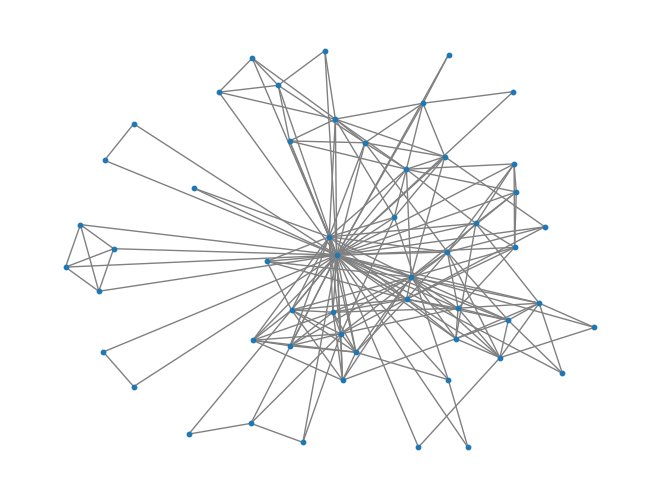

In [39]:
import networkx as nx
import matplotlib.pyplot as plt

def draw_graph(graph:Graph):
    G = nx.Graph()
    G.add_edges_from(graph.edges)
    nx.draw(G, with_labels=False, node_size=10, edge_color='gray')
    plt.show()
    
graph = load_subgraph(node_id)
draw_graph(graph)

In [40]:
# reindex the nodes
def reindex_nodes(graph:Graph) -> Graph:
    # use 1-based index, ego node's index is 1
    nodes = list(graph.nodes)
    nodes.remove(graph.ego)
    nodes = sorted(nodes)
    nodes.insert(0, graph.ego)
    nodes = {node: i+1 for i, node in enumerate(nodes)}
    edges = [(nodes[u], nodes[v]) for u, v in graph.edges]
    nodes = set(nodes.values())
    return Graph(1, nodes, edges)
    

print(reindex_nodes(load_subgraph(3980)).nodes)


{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53}


In [41]:
# generate subgraph data
def generate_subgraph_data(num_nodes, graph:Graph) -> Graph:
    graph = reindex_nodes(graph)
    # randomly select num_nodes nodes and keep the ego node
    selected_nodes = set()
    selected_nodes.add(1)
    
    while len(selected_nodes) < num_nodes:
        node = np.random.choice(list(graph.nodes))
        selected_nodes.add(node)
    
    # generate subgraph
    subgraph_nodes = set(selected_nodes)
    subgraph_edges = []
    for u, v in graph.edges:
        if u in subgraph_nodes and v in subgraph_nodes:
            subgraph_edges.append((u, v))
            
    return Graph(1, subgraph_nodes, subgraph_edges)
    

In [42]:
# generate graph data
# data should follow the format of:
# [N:number of nodes] [M:number of edges]
# [T:number of targets] [target_id_1] [target_id_2] .....[target_id_T] 
# [𝑘: number of edges to be added] [𝜏:LCC degradation] [𝜔𝑏] [𝜔𝑐] [𝜔𝑐] 
# [edge_1_v1] [edge_1_v2] 
# [edge_2_v1] [edge_2_v2] 
# ... 
# [edge_M_v1] [edge_M_v2] 

def generate_graph_data(graph:Graph, file_name:str, target_ids=[], k=0, tau=0.4, omega_b=0.001, omega_c=0.001, omega_d=0.001):
    graph = reindex_nodes(graph)
    nodes = graph.nodes
    edges = graph.edges
    
    if len(target_ids) == 0:
        # randomly select 10% of the nodes as target nodes
        target_ids = np.random.choice(list(nodes), int(len(nodes) * 0.1), replace=False)
    
    N = len(nodes)
    M = len(edges)
    T = len(target_ids)
    
    if k == 0:
        max_k = N * (N - 1) // 2 - M
        # randomly select a number of edges to be added
        k = np.random.randint(len(target_ids), min(max_k, 20))
    
    with open(file_name, "w") as f:
        f.write(f"{N} {M}\n")
        f.write(f"{T} {' '.join(map(str, target_ids))}\n")
        f.write(f"{k} {tau} {omega_b} {omega_c} {omega_d}\n")
        for u, v in edges:
            f.write(f"{u} {v}\n")
    
    print(f"Graph data generated: {file_name}")

In [43]:
node_id = 698
# set seed
np.random.seed(0)
graph = load_subgraph(node_id)
graph = reindex_nodes(graph)
generate_graph_data(graph, f"../data/test/{node_id}.txt")

Graph data generated: ../data/test/698.txt


In [44]:
node_id = 3980
# set seed
np.random.seed(0)
graph = load_subgraph(node_id)
small_graph = generate_subgraph_data(10, graph)
generate_graph_data(small_graph, f"../data/test/{node_id}_small.txt", k=5)

Graph data generated: ../data/test/3980_small.txt


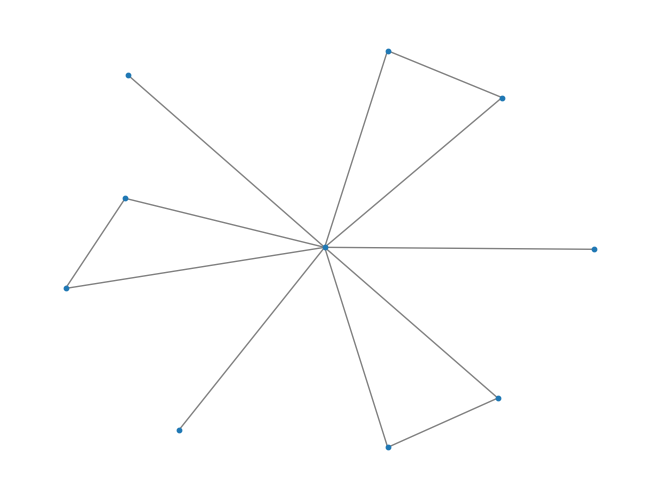

In [45]:
draw_graph(small_graph)